# Elastic FWI on Marmousi II using CGG data setup


by Oleg Ovcharenko

oleg.ovcharenko@kaust.edu.sa

KAUST, 2021

In [6]:
import os
import sys
import copy
import glob
import numpy as np
import importlib
import multiprocessing

import segyio
from scipy import signal, ndimage
from natsort import natsorted
from skimage.transform import rescale, resize

import shared as sd
import loaders as ld
import vis

from IPython.display import clear_output

# MAKE SURE THIS POINTS TO WHRE DENISE IS
sys.path.append(os.path.abspath('../'))
import pyapi_denise as api
print(f'Python: {sys.prefix}')

Python: /home/ovcharoo/work/env_torch


In [7]:
# # This is to prevent error "this loop already runnign when doing magical %run <<notebook name>>"
import nest_asyncio
nest_asyncio.apply()

In [8]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# mpl.rcParams['figure.dpi']= 100
fontsize = 10
params = {
    # 'text.latex.preamble': ['\\usepackage{gensymb}'],
    # 'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'figure.dpi' : 100,
    # 'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize':fontsize,  # fontsize for x and y labels (was 10)
    'axes.titlesize':fontsize,
    'font.size':fontsize,  # was 10
    'legend.fontsize': fontsize,  # was 10
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize,
    # 'text.usetex': True,
    # 'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
mpl.rcParams.update(params)

### Where to save outputs

In [9]:
root_fwi = './out_for_pasha_marm/'

# Init Denise API

In [10]:
importlib.reload(api)
denise_root = '../den/'
d = api.Denise(denise_root, verbose=1)

Init Python 3 API for Denise-Black-Edition.
Check binary in ../den/bin/denise
Parse ../den/par/DENISE_marm_OBC.inp
Current directory is /home/ovcharoo/work/for_pasha
Init paths at ./outputs/


In [11]:
# d.parser_report()

## Work directory
Where to output everything

In [12]:
d.save_folder = root_fwi
d.set_paths()

Current directory is /home/ovcharoo/work/for_pasha
Init paths at ./out_for_pasha_marm/


# Get acquitision details

In [13]:
shot_id_min = 60
n_selected_shots = 80
njump_src = 8
shot_id_max = shot_id_min + (n_selected_shots-1) * njump_src

In [14]:
%run ./fwi_shared_check.ipynb

80/80
Before prep:	(80, 648, 3526)
Data cube:	(80, 324, 3000)
Extended cube:	(80, 324, 3100)
[80, 324, 3050] (80, 324, 3000)
[80, 324, 3150] (80, 324, 3100)
Assume even averacge spacing between sources
 150.0 m ~ 6 grid nodes
First source:	1125.0 m
Last source:	12950.0 m
name:	
x	(80,):	min: 1125.0	max: 12975.0
y	(80,):	min: 50.0	max: 50.0
wavelets:	None
z	(80,):	min: 0.0	max: 0.0
nshot:	80
td	(80,):	min: 0.0	max: 0.0
fc	(80,):	min: 8.0	max: 8.0
amp	(80,):	min: 1.0	max: 1.0
angle	(80,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(80,):	min: 1.0	max: 1.0
drec:	25.0 m
x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
name:	]


In [15]:
print('Field data spacing between sources {:.2f} m'.format(np.mean(src_.x[1:] - src_.x[:-1])))

Field data spacing between sources 149.75 m


In [16]:
vp_baseline = vp.copy()
print(vp.shape)

marm_path = os.path.join(root_fwi, 'start/')
os.makedirs(marm_path, exist_ok=True)
print(marm_path)
if not 'marmousi_II_marine.vp' in os.listdir(marm_path):
    # Download Marmousi II model
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.vp -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.vs -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_marine.rho -P {marm_path}')

    # Download initial model for FWI
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.vp -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.vs -P {marm_path}')
    os.system(f'wget https://github.com/daniel-koehn/DENISE-Benchmark/raw/master/Marmousi-II/start/marmousi_II_start_1D.rho -P {marm_path}')
    
def get_vp_vs_rho(vp):
    vp = extend(vp, 15, 0)

    print(f'Reshape {vp.shape} into {wb_taper.shape}...')

    vp = resize(vp, wb_taper.shape, anti_aliasing=True)
    vp = np.where(vp <= 1500.0, 1490.0, vp)
    vp = extend(vp, 0, 264 + 10 * 8)

    # shear velocity, [m/s]
    vs = vp.copy() / (3 ** 0.5)
    vs = np.where(vp < 1.01 * np.min(vp), 0, vs)

    # density, [kg/m3] 
    rho = 1e3*0.3 * vp.copy()**0.25
    rho = np.where(vp < 1.01 * np.min(vp), 1000, rho)
    return vp, vs, rho

(152, 600)
./out_for_pasha_marm/start/


# REPLACE MODEL BY MARMOUSI TO GENERATE "FIELD" DATA

In [17]:
vp_marm = load_bin(f'{marm_path}marmousi_II_marine.vp', (500, 174))[:, 100:]
print(vp_marm.min(), vp_marm.max())

# This is what was used in generation of training data
box_min = 1490.
box_max = 4000. 

vmin_marm = vp_marm.min()
vp_marm -= vmin_marm

vmax_marm = vp_marm.max()
vp_marm /= vmax_marm
vp_marm = box_min  + vp_marm * (box_max - box_min)
print(vp_marm.min(), vp_marm.max())

(174, 500)
1500.0 4766.604
1490.0 4000.0


Reshape (189, 400) into (152, 600)...
vp:	(152, 944), 1490.0000, 4000.0000 m/s

vs:	(152, 944), 0.0000, 2309.4011 m/s

rho:	(152, 944), 1000.0000, 2385.8122 m/s

dx:	25.0000
Size:
	OX:	min 0.0000	max 23575.0000 m
Size:
	OZ:	min 0.0000	max 3775.0000 m


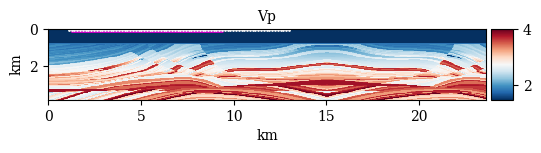

In [18]:
vp, vs, rho = get_vp_vs_rho(vp_marm)
vis.plot_acquisition(vp, dx, src, rec, title='Vp')
model = api.Model(vp, vs, rho, dx)
print(model)

## Model prepared by Daniel Kohn from Kiel University

(174, 500)
Reshape (189, 400) into (152, 600)...
vp:	(152, 944), 1490.0000, 4000.0000 m/s

vs:	(152, 944), 0.0000, 2309.4011 m/s

rho:	(152, 944), 1000.0000, 2385.8122 m/s

dx:	25.0000
Size:
	OX:	min 0.0000	max 23575.0000 m
Size:
	OZ:	min 0.0000	max 3775.0000 m


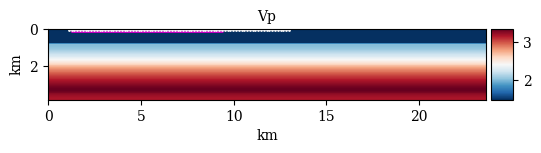

In [20]:
vp_marm_linear = load_bin(f'{marm_path}marmousi_II_start_1D.vp', (500, 174))[:, 100:]
vp_marm_linear -= vmin_marm
vp_marm_linear /= vmax_marm
vp_marm_linear = box_min  + vp_marm_linear * (box_max - box_min)

vp_linear, vs_linear, rho_linear = get_vp_vs_rho(vp_marm_linear)
vis.plot_acquisition(vp_linear, dx, src, rec, title='Vp')
model_linear = api.Model(vp_linear, vs_linear, rho_linear, dx)

log_linear = vp_linear[:, log_idx]
print(model)

## Acquisition design

vp:	(152, 944), 1490.0000, 4000.0000 m/s

vs:	(152, 944), 0.0000, 2309.4011 m/s

rho:	(152, 944), 1000.0000, 2385.8122 m/s

dx:	25.0000
Size:
	OX:	min 0.0000	max 23575.0000 m
Size:
	OZ:	min 0.0000	max 3775.0000 m


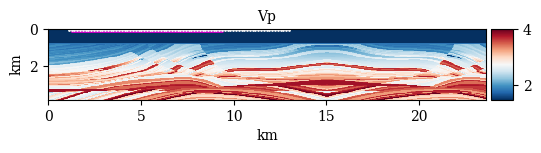

In [21]:
# Set custom wavelet
wls = bpw[:, ::2]
src.wavelets = wls[:, :limit_nt]

vis.plot_acquisition(vp, dx, src, rec, title='Vp')
print(model)

Save /home/ovcharoo/Dropbox/WORK_HARD/low_elastic/tex/GEOPHYSICS_21/pic/vinit.png


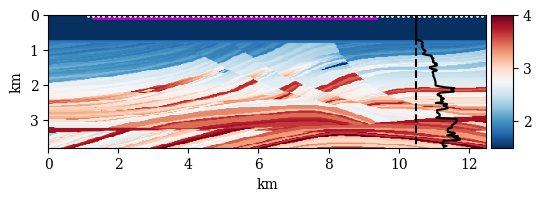

In [22]:
log = model.vp[:, log_idx]
# model_log = copy.deepcopy(model)

log_dict = {'data':log/2, 'loc': log_loc}
vis.plot_acquisition(vp[:, :500], dx, src, rec, log=log_dict)
vis.savefig('vinit.png')

Text(0.5, 0, 'Depth, km')

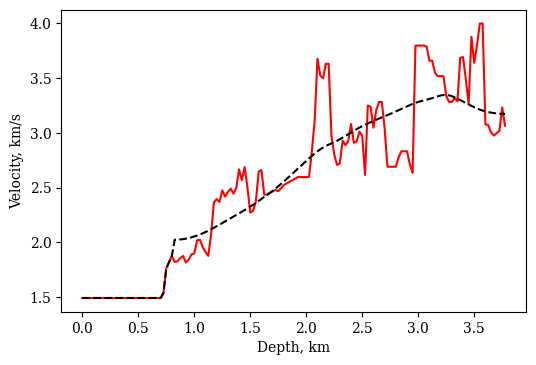

In [23]:
fig, ax = plt.subplots(1,1); 
# ax_depth = np.arange(len(wlog)) * dx / 1000
ax_depth = np.arange(len(log)) * dx / 1000
# ax.plot(ax_depth, wlog[::-1] / 1000, 'b', label='CGG')
ax.plot(ax_depth, log[::-1] / 1000, 'r', label='Well')
ax.plot(ax_depth, log_linear[::-1] / 1000, 'k--', label='Init')
ax.set_ylabel('Velocity, km/s')
ax.set_xlabel('Depth, km')

In [24]:
print(src, end='\n\n------------\n')
print(rec)

name:	
x	(80,):	min: 1125.0	max: 12975.0
y	(80,):	min: 50.0	max: 50.0
wavelets	(80, 3000):	min: -5.2003522040678645	max: 6.286853676317875
z	(80,):	min: 0.0	max: 0.0
nshot:	80
td	(80,):	min: 0.0	max: 0.0
fc	(80,):	min: 8.0	max: 8.0
amp	(80,):	min: 1.0	max: 1.0
angle	(80,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(80,):	min: 1.0	max: 1.0

------------
x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 1275.0	max: 9350.0
y	(324,):	min: 100.0	max: 100.0
name:	]


## Generate true waveforms

Set some runtime parameters which are different from defaults. Check defaults by runnning `help()`

In [25]:
# Elastic modeling
d.verbose = 1
d.PHYSICS = 1
d.SEISMO = 2
d.DT = dDT
d.NT = data_p.shape[-1]
d.TIME = dDT * d.NT
#
d.FC_SPIKE_2 = 10
d.REC_INCR_X = dsrc
d.N_STREAMER = len(rec)

# d.TESTSHOT_START = np.round(0.1 * len(src))
# d.TESTSHOT_END = np.round(0.9 * len(src))
# d.TESTSHOT_INCR = 5

d.TESTSHOT_START = 1
d.TESTSHOT_END = len(src)
d.TESTSHOT_INCR = 10

d.QUELLTYPB = 4
d.QUELLART = 3  

d.WRITE_STF = 0

# Acoustic case 
# d.PHYSICS = 2
# src.wavelets = -wls[:, :limit_nt]

print(d.DT, d.NT)

0.002 3000


### Run forward modeling

In [26]:
d.NPROCX = 1
d.NPROCY = 1
par_forward = {'run_command': 'mpirun -np 28', 'disable': False}

In [27]:
d.forward(model, src, rec, **par_forward)

Current directory is /home/ovcharoo/work/for_pasha
Init paths at ./out_for_pasha_marm/
Init model:
	152 x 944, dx = 25.0 m
Check max source frequency:
	min Vs: 871.7581001035492 m/s
	min Vp: 1490.0 m/s
	Number of gridpoints per minimum wavelength = 3.69
	Maximum source wavelet frequency = 9.44995230464552 Hz
Check domain decomposition for parallelization:
	in X-direction, NX % NPROCX, 944 % 1 = 0
	in Y-direction, NY % NPROCY, 152 % 1 = 0
Write ./out_for_pasha_marm/start/model.vp
Write ./out_for_pasha_marm/start/model.vs
Write ./out_for_pasha_marm/start/model.rho
Enable streamer mode!
	source 1: ./out_for_pasha_marm/receiver/receivers_shot_1
	source 2: ./out_for_pasha_marm/receiver/receivers_shot_2
	source 3: ./out_for_pasha_marm/receiver/receivers_shot_3
	source 4: ./out_for_pasha_marm/receiver/receivers_shot_4
	source 5: ./out_for_pasha_marm/receiver/receivers_shot_5
	source 6: ./out_for_pasha_marm/receiver/receivers_shot_6
	source 7: ./out_for_pasha_marm/receiver/receivers_shot_7
	so

	wavelet 62: ./out_for_pasha_marm/wavelet/wavelet_shot_62.dat
	wavelet 63: ./out_for_pasha_marm/wavelet/wavelet_shot_63.dat
	wavelet 64: ./out_for_pasha_marm/wavelet/wavelet_shot_64.dat
	wavelet 65: ./out_for_pasha_marm/wavelet/wavelet_shot_65.dat
	wavelet 66: ./out_for_pasha_marm/wavelet/wavelet_shot_66.dat
	wavelet 67: ./out_for_pasha_marm/wavelet/wavelet_shot_67.dat
	wavelet 68: ./out_for_pasha_marm/wavelet/wavelet_shot_68.dat
	wavelet 69: ./out_for_pasha_marm/wavelet/wavelet_shot_69.dat
	wavelet 70: ./out_for_pasha_marm/wavelet/wavelet_shot_70.dat
	wavelet 71: ./out_for_pasha_marm/wavelet/wavelet_shot_71.dat
	wavelet 72: ./out_for_pasha_marm/wavelet/wavelet_shot_72.dat
	wavelet 73: ./out_for_pasha_marm/wavelet/wavelet_shot_73.dat
	wavelet 74: ./out_for_pasha_marm/wavelet/wavelet_shot_74.dat
	wavelet 75: ./out_for_pasha_marm/wavelet/wavelet_shot_75.dat
	wavelet 76: ./out_for_pasha_marm/wavelet/wavelet_shot_76.dat
	wavelet 77: ./out_for_pasha_marm/wavelet/wavelet_shot_77.dat
	wavelet

Read 80 shots (324, 3000) into list


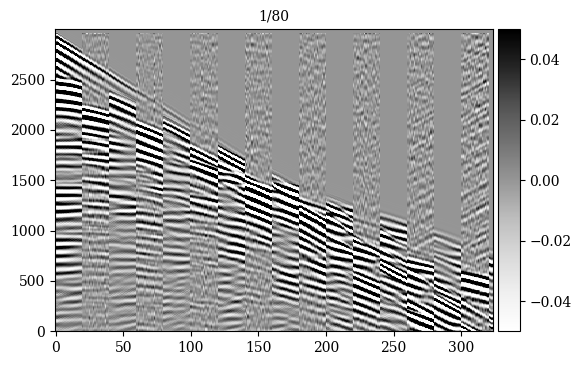

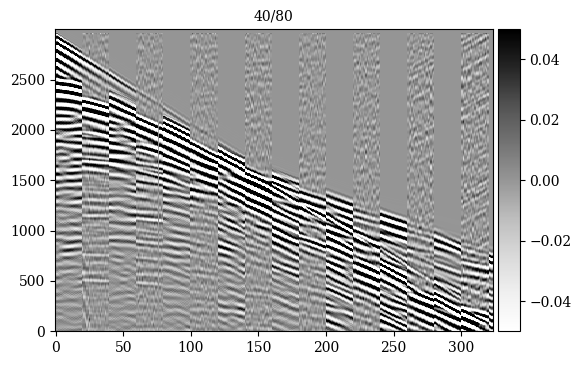

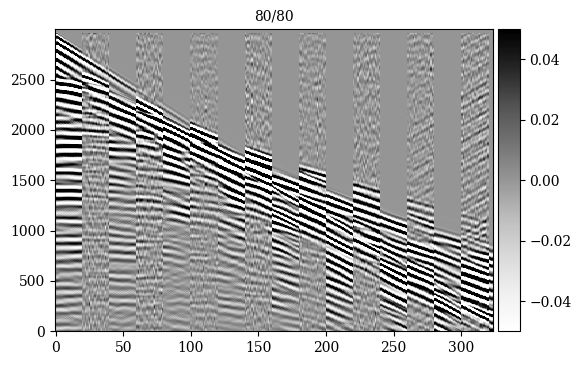

In [28]:
d.verbose = 0    # don't show redundant print outs

if d.DT is None:
    d.DT = 0.002
shots = d.get_shots(keys=['_p.'])

par_shot = {'vmin': -0.05, 'vmax': 0.05}
if shots:
    print(f'Read {len(shots)} shots {shots[0].shape} into list')
    for i in [int(np.floor(x)) for x in np.linspace(0, len(shots)-1, 3)]:
        try:
            shot_s = divmax(shots[i])
            shot_f = divmax(data_p[i, :, ::d.NDT])
            vis.plot_compare_stripes(shot_s, shot_f, title=f'{i+1}/{len(shots)}', **par_shot)
        except:
            print(f'Failed to fetch data for i={i}')

In [29]:
print(src.x[48])

8325.0


# Compare syn and field

Total sources: 80
Syn wavelets:	(80, 500)	-250.17	344.49
Field wavelets:	(80, 500)	-231.76	344.49
[0, 8, 17, 26, 35, 43, 52, 61, 70, 79]


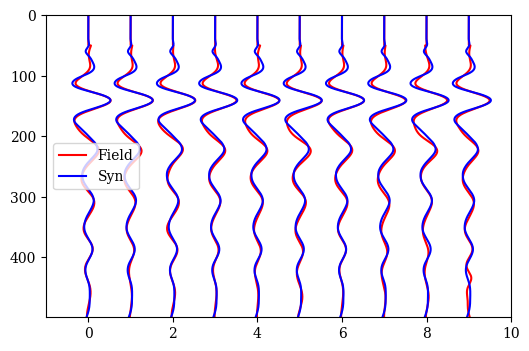

In [30]:
wavelets_s = []
wavelets_f = []
for i, shot in enumerate(shots):
    no, nt = 1, 500
    wavelets_s.append(shot[:no, :nt].copy())
    wavelets_f.append(data_p[i, :no, :nt:d.NDT].copy())
print(f'Total sources: {len(wavelets_f)}')
wavelets_s = np.concatenate(wavelets_s, 0)
wavelets_f = np.concatenate(wavelets_f, 0)

# !!! DO THIS IN FIELD DATA APPLICATION !!!
# THIS MAKES SYNTHETIC AND FIELD COMPARABLE
# OTHERWISE THERE IS INSANE AMPLITUDE MISMATCH
wavelets_f /= np.max(wavelets_f)
wavelets_f *= wavelets_s.max()

print('Syn wavelets:\t{}\t{:.2f}\t{:.2f}'.format(wavelets_s.shape, wavelets_s.min(), wavelets_s.max()))
print('Field wavelets:\t{}\t{:.2f}\t{:.2f}'.format(wavelets_f.shape, wavelets_f.min(), wavelets_f.max()))

vis.plot_wiggles([wavelets_f, wavelets_s], n=10, colors=['r', 'b'], legend=['Field', 'Syn'])

Save /home/ovcharoo/Dropbox/WORK_HARD/low_elastic/tex/GEOPHYSICS_21/pic/wavelet_syn_field.png


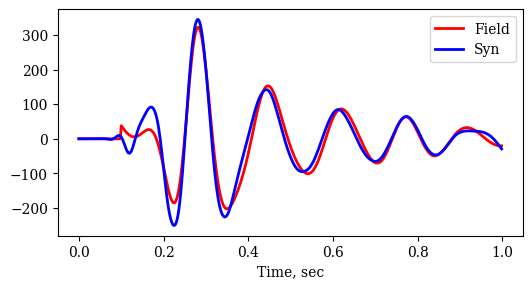

In [31]:
if shots:
    tvec = np.arange(nt) * d.DT
    plt.figure(figsize=(6,3)); 
    trace_idx = 0
    plt.plot(tvec, wavelets_f[trace_idx,:], 'r', lw=2, label='Field')
    plt.plot(tvec, wavelets_s[trace_idx,:], 'b', lw=2, label='Syn')
    # plt.plot(tvec, _dplotted[0][0], 'r', lw=2, label='Field')
    # plt.plot(tvec, _dplotted[1][0], 'b', lw=2, label='Syn')
    plt.legend()
    plt.xlabel('Time, sec')
    vis.savefig('wavelet_syn_field.png')

# REPLACE FIELD DATA BY MARM DATA

In [33]:
data_p = np.concatenate([np.expand_dims(s, 0) for s in shots], 0)
print(data_p.shape)

(80, 324, 3000)


In [34]:
data_p_backup = data_p.copy()
print(data_p_backup.shape, d.DT)

(80, 324, 3000) 0.002


(80, 324, 3000) -36872.38619092324 29173.327396346955


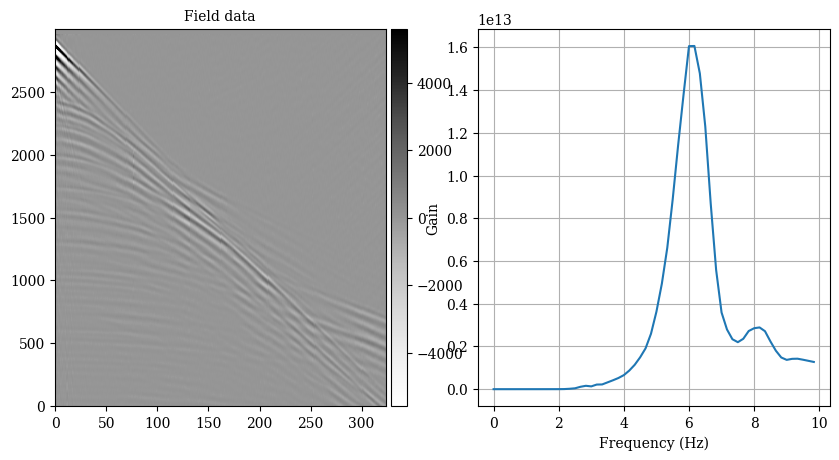

In [32]:
# data_p = np.concatenate([np.expand_dims(s, 0) for s in shots], 0)
print(data_p.shape, data_p.min(), data_p.max())
dref = np.mean(data_p, 0)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
vis.plot_shot(dref, title='Field data', pclip=0.25, colorbar=True, ax=ax[0])
vis.plot_spectrum(dref, dt=0.002, fmax=10, title='Spectrum', ax=ax[1])

## Save field data to a new folder in /su/

In [35]:
def copy_su_from_to(path_from, path_to):
    """ Copy files matching *.su.* from one folder to another folder"""
    os.makedirs(path_to, exist_ok=True)
    su_files = glob.glob(path_from + '/*.su.*')
    su_files = [f for f in su_files if '.it' not in f]
    print(f'Found {len(su_files)} *.su.* files in {path_from}')

    commands = []
    print(f'Copy files from {path_from} to {path_to}')
    for f in su_files:
        commands.append(f'cp {f} {path_to}')
    with multiprocessing.Pool() as pool:
        pool.map(os.system, commands)

In [36]:
root_su_field = os.path.join(d._root_su, 'field/')
copy_su_from_to(d._root_su, root_su_field)

Found 80 *.su.* files in ./out_for_pasha_marm/su
Copy files from ./out_for_pasha_marm/su to ./out_for_pasha_marm/su/field/


In [37]:
def get_fnames_pattern(pattern):    
    fnames = natsorted(glob.glob(pattern))
    fnames = [f for f in fnames if '.it' not in f]
    print(f'{len(fnames)} files found in {pattern}')
    return fnames

fnames = get_fnames_pattern(root_su_field + '*.su.*')

80 files found in ./out_for_pasha_marm/su/field/*.su.*


In [38]:
wb_taper = np.where(model.vp < 1.01 * model.vp.min(), 1, 0)
nx0 = 500
limits_vp = {'vmin': model.vp.min() / 1000, 'vmax': model.vp.max() / 1000}
limits_vs = {'vmin': model.vs.min() / 1000, 'vmax': model.vs.max() / 1000}
limits_rho = {'vmin': model.rho.min() / 1000, 'vmax': model.rho.max() / 1000}

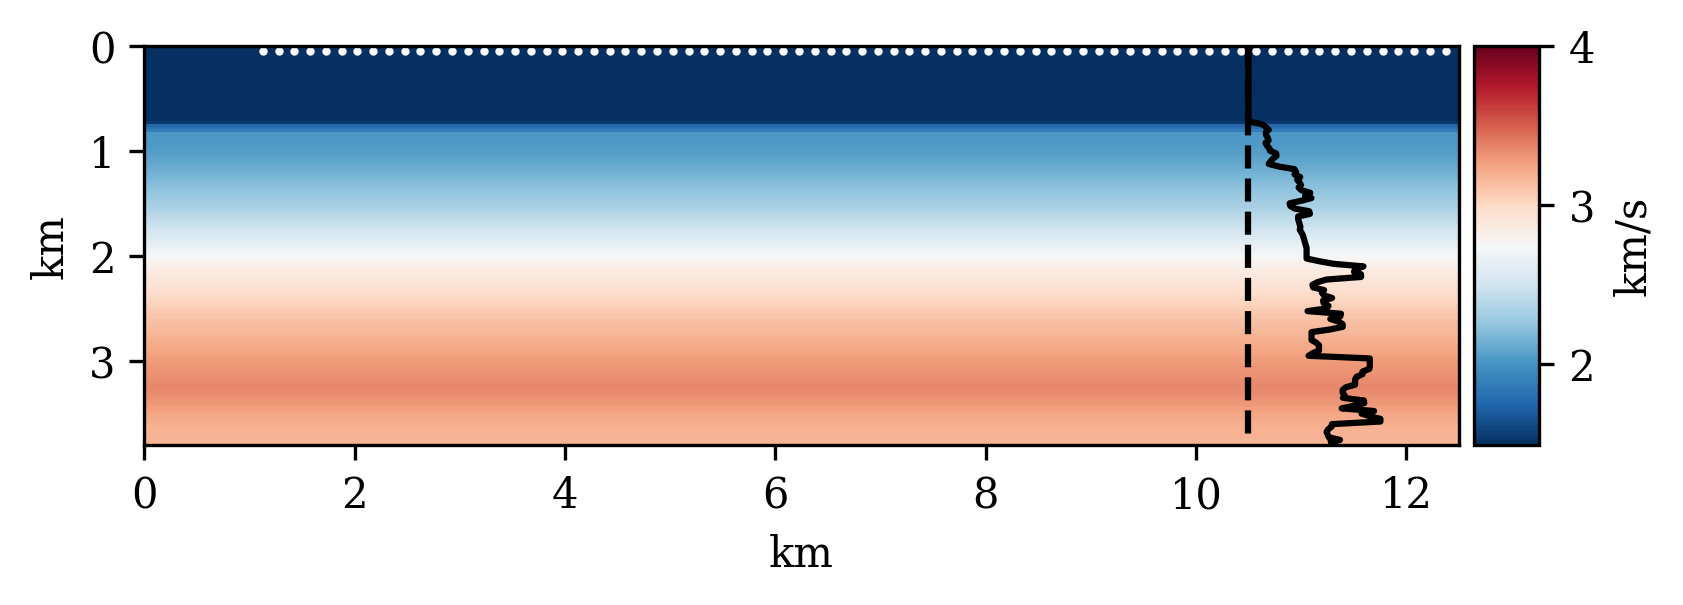

In [39]:
mpl.rcParams['figure.dpi']= 300
vis.plot_log_model(vp_linear, dx, nx0, nz0, src, log=log / 2, log_location=log_location, **limits_vp)
mpl.rcParams['figure.dpi']= 100

## Crop predicted model
Large part of the model (beyond last source) was only to get full-offset seismic data. When running inversion it is not needed so we cut it down

In [48]:
model_init = copy.copy(model_linear)
print(model_init)

vp:	(152, 944), 1490.0000, 3346.2265 m/s

vs:	(152, 944), 0.0000, 1931.9448 m/s

rho:	(152, 944), 1000.0000, 2281.7081 m/s

dx:	25.0000
Size:
	OX:	min 0.0000	max 23575.0000 m
Size:
	OZ:	min 0.0000	max 3775.0000 m


(116, 1) (152, 944)


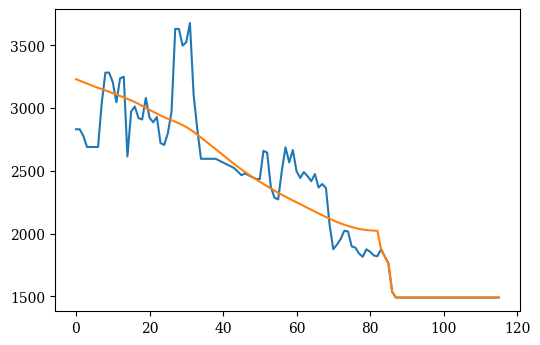

In [50]:
print(wlog.shape, vp.shape)

fig, ax = plt.subplots(1,1)
ax.plot(vp[-len(wlog):, log_idx])
ax.plot(model_init.vp[-len(wlog):, log_idx])

# Full-waveform inversion
Invert for elastic properties `vp`, `vs` and `rho`, given `x` and `y` velocity components of wavefield 

## Initial velocity model
Smooth background model with true water bottom and shallow sediments

116 (152, 944) 116


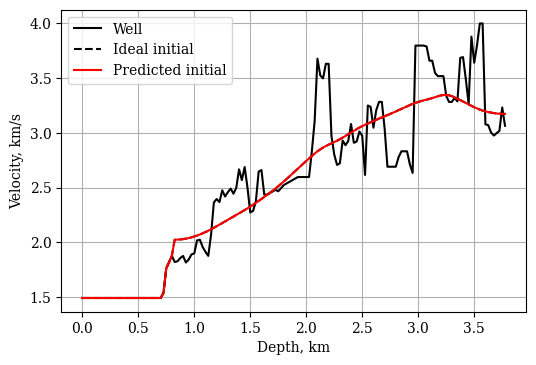

In [51]:
# ax = plot_model(np.concatenate((model_init.vp, model_init.vs, model_init.rho), 1))
# plot_logs(model_log, model_init, log_idx)

fig, ax = plt.subplots(1,1); 
# ax_depth = np.arange(len(wlog)) * dx / 1000
ax_depth = np.arange(len(log_linear)) * dx / 1000
ax.plot(ax_depth, log[::-1] / 1000, 'k', label='Well')
ax.plot(ax_depth, log_linear[::-1] / 1000, 'k--', label='Ideal initial')

# log_pred = model_init.vp[-len(wlog):, log_idx]

log_pred = model_init.vp[-len(log):, log_idx]
ax.plot(ax_depth, log_pred[::-1] / 1000, 'r', label='Predicted initial')

nwater = 33#33
dummy = np.zeros_like(model.vp)
dummy[-nwater:, :] = 1.
log_taper = np.min(log_pred) + dummy[:, log_idx] * (np.max(log_pred) - np.min(log_pred))
log_taper = np.min(log_pred) + wb_taper[-len(wlog):, log_idx] * (np.max(log_pred) - np.min(log_pred))
# ax.plot(ax_depth, log_taper[::-1]  / 1000, 'b', label='Taper')
# 
# ax.plot(ax_depth, log_linear[::-1] / 1000, 'k--', label='Linear')
ax.set_ylabel('Velocity, km/s')
ax.set_xlabel('Depth, km')
ax.grid(True)
ax.legend()

print(len(wlog), model_init.vp.shape, len(model_init.vp[:len(wlog)]))

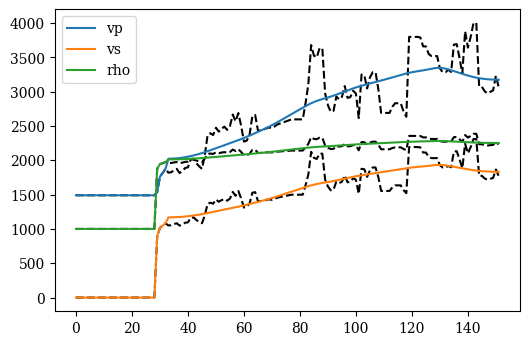

In [52]:
plot_logs(model, model_init, log_idx)

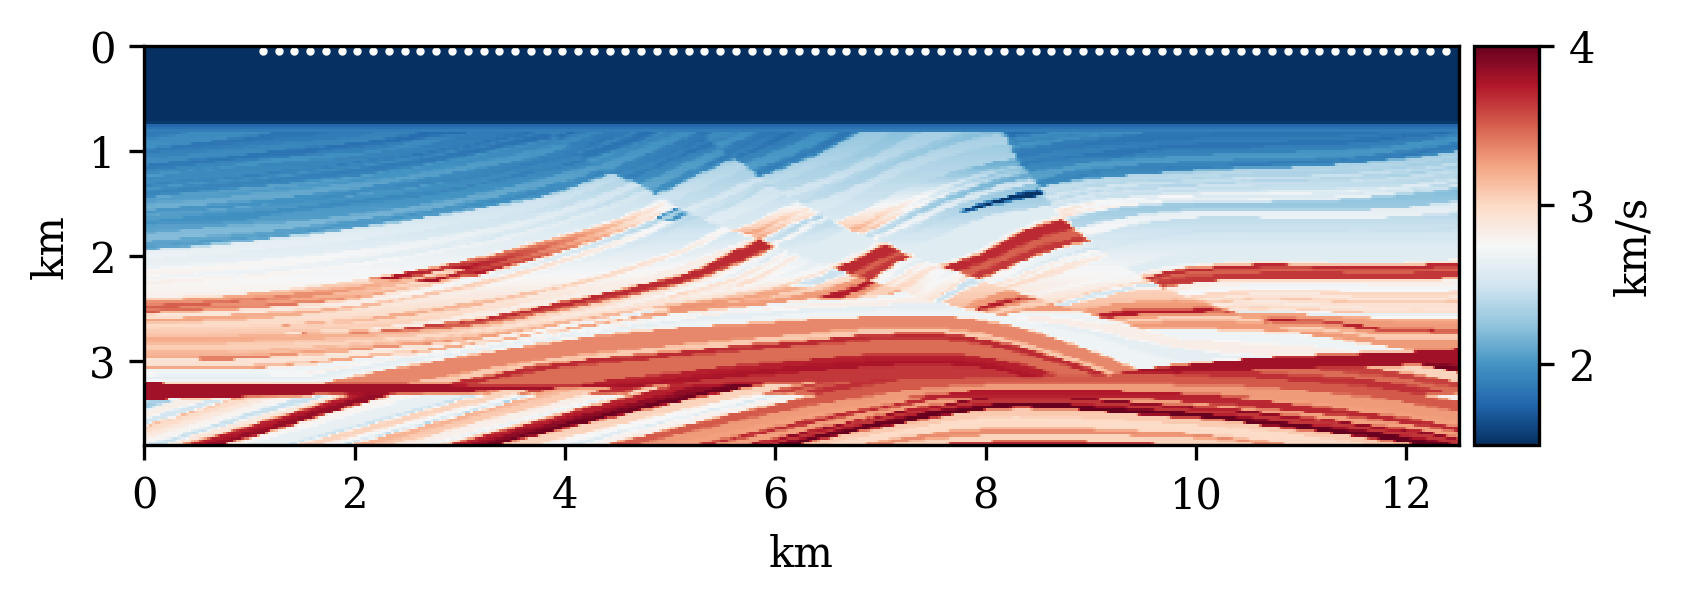

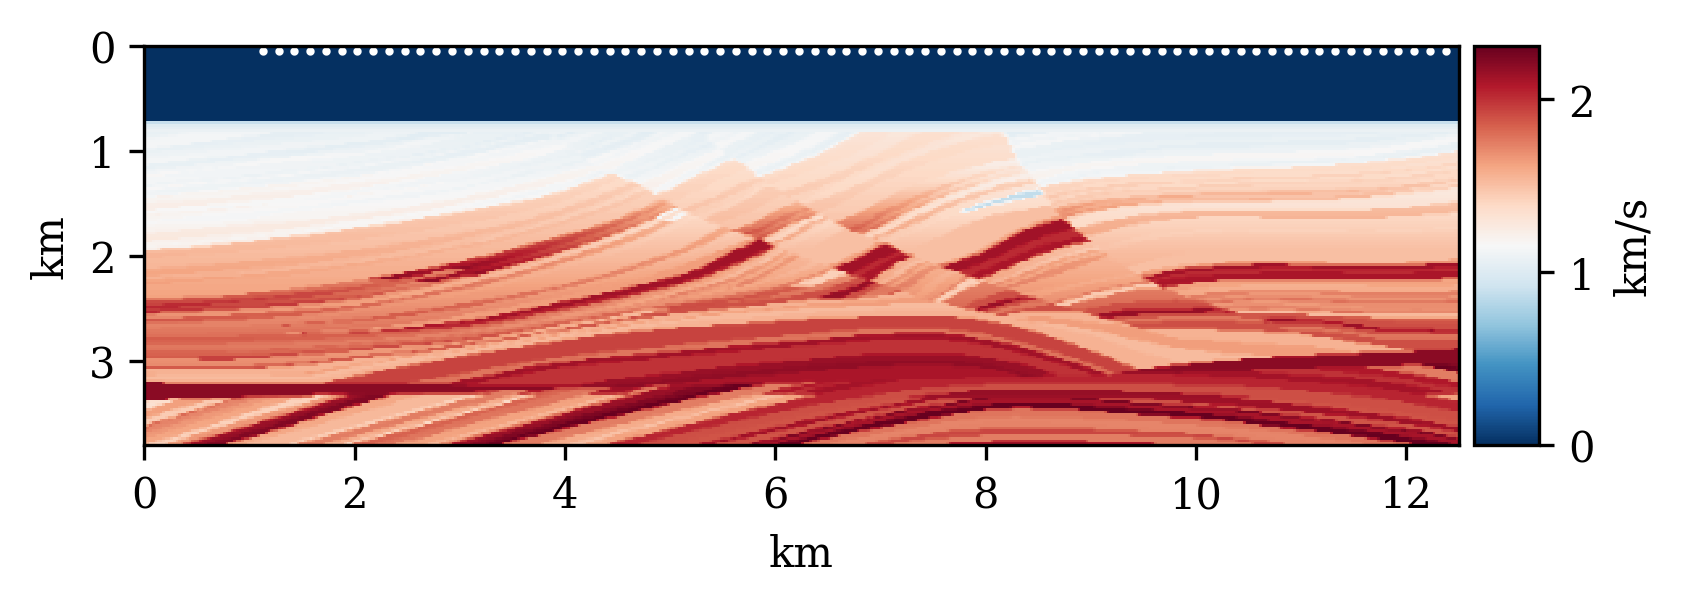

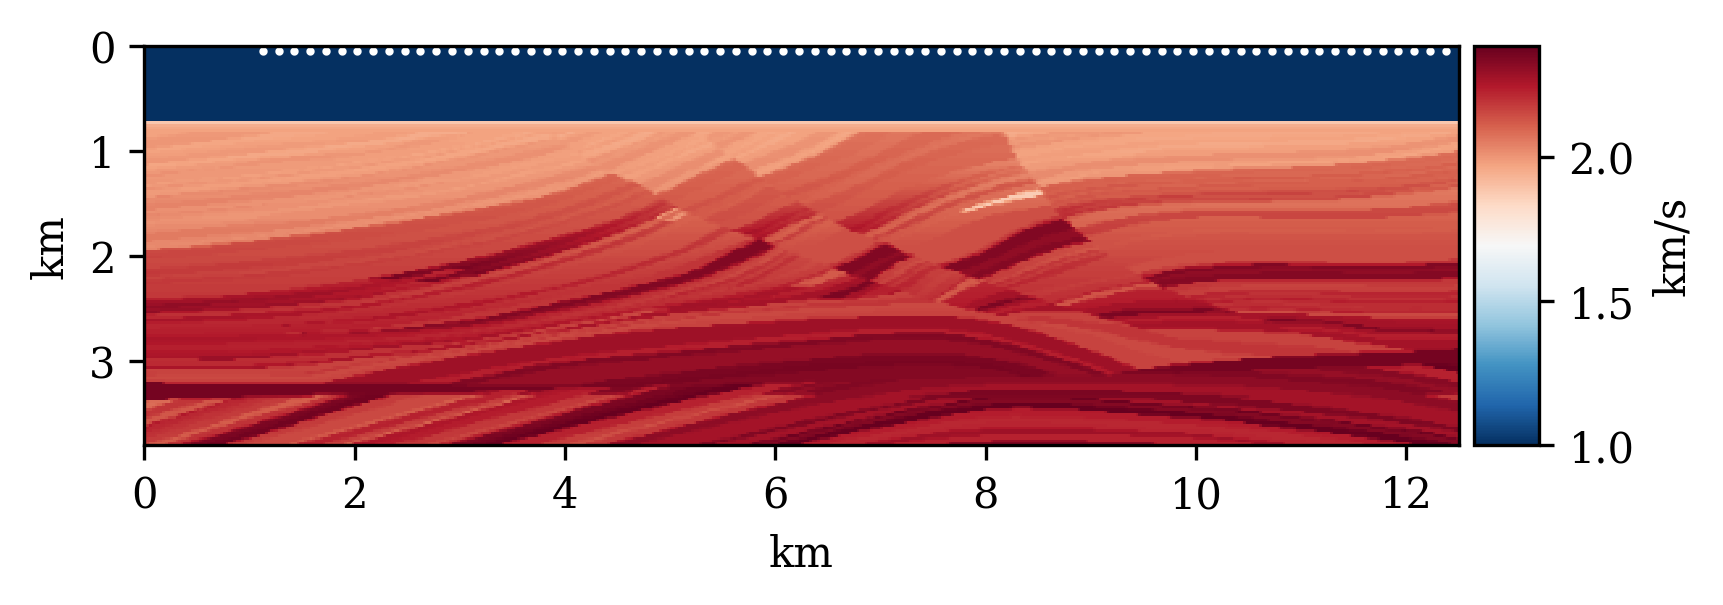

In [53]:
mpl.rcParams['figure.dpi']= 300
vis.plot_log_model(model.vp, dx, nx0, nz0, src, **limits_vp)
vis.plot_log_model(model.vs, dx, nx0, nz0, src, **limits_vs)
vis.plot_log_model(model.rho, dx, nx0, nz0, src, **limits_rho)
mpl.rcParams['figure.dpi']= 100

## Stages of inversion
Use default parameters, except high- and low-pass corner frequencies of Butterworth filter

In [57]:
par_stages_fwi = {'inv_vs_iter': 0,
                 'inv_rho_iter': 0,
                 'normalize': 2,
                 'order': 6,
                 }

d.fwi_stages = []
freqs_high = [3, 4, 5, 6, 7, 8]
grad_smoothing = [2, 1.5, 1.0, 0.5, 0.25, 0.125]
spatfilters = [4, 4, 0, 0, 0, 0]
for i, freq in enumerate(freqs_high):
    d.add_fwi_stage(fc_high=freq, 
                    wd_damp=grad_smoothing[i],
                    wd_damp1=grad_smoothing[i],
                    spatfilter=spatfilters[i],
                    **par_stages_fwi)
    print(f'Stage {i+1}:\n\t{d.fwi_stages[i]}\n')

Stage 1:
	{'PRO': 0.01, 'TIME_FILT': 1, 'FC_LOW': 0.0, 'FC_HIGH': 3, 'ORDER': 6, 'TIME_WIN': 0, 'GAMMA': 20, 'TWIN-': 0.0, 'TWIN+': 0.0, 'INV_VP_ITER': 0, 'INV_VS_ITER': 0, 'INV_RHO_ITER': 0, 'INV_QS_ITER': 0, 'SPATFILTER': 4, 'WD_DAMP': 2, 'WD_DAMP1': 2, 'EPRECOND': 3, 'LNORM': 2, 'ROWI': 0, 'STF_INV': 0, 'OFFSETC_STF': -4.0, 'EPS_STF': 0.1, 'NORMALIZE': 2, 'OFFSET_MUTE': 0, 'OFFSETC': 10, 'SCALERHO': 0.5, 'SCALEQS': 1.0, 'ENV': 1, 'N_ORDER': 0}

Stage 2:
	{'PRO': 0.01, 'TIME_FILT': 1, 'FC_LOW': 0.0, 'FC_HIGH': 4, 'ORDER': 6, 'TIME_WIN': 0, 'GAMMA': 20, 'TWIN-': 0.0, 'TWIN+': 0.0, 'INV_VP_ITER': 0, 'INV_VS_ITER': 0, 'INV_RHO_ITER': 0, 'INV_QS_ITER': 0, 'SPATFILTER': 4, 'WD_DAMP': 1.5, 'WD_DAMP1': 1.5, 'EPRECOND': 3, 'LNORM': 2, 'ROWI': 0, 'STF_INV': 0, 'OFFSETC_STF': -4.0, 'EPS_STF': 0.1, 'NORMALIZE': 2, 'OFFSET_MUTE': 0, 'OFFSETC': 10, 'SCALERHO': 0.5, 'SCALEQS': 1.0, 'ENV': 1, 'N_ORDER': 0}

Stage 3:
	{'PRO': 0.01, 'TIME_FILT': 1, 'FC_LOW': 0.0, 'FC_HIGH': 5, 'ORDER': 6, 'TIME_WIN':

In [58]:
d.SWS_TAPER_GRAD_HOR = 1
d.GRADT1, d.GRADT2 = 25, 30

(152, 944) (152, 944)
Save (944, 152) as binary to ./out_for_pasha_marm/taper/taper.bin
Save (944, 152) as binary to ./out_for_pasha_marm/taper/taper_u.bin
Save (944, 152) as binary to ./out_for_pasha_marm/taper/taper_rho.bin


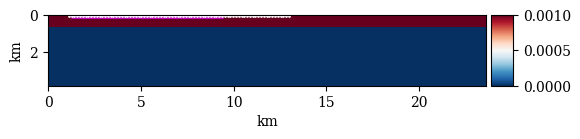

In [59]:
# import loaders as ld
# # Gradient tapering
# d.SWS_TAPER_GRAD_VERT = 0
# d.SWS_TAPER_GRAD_HOR = 0
# d.SWS_TAPER_CIRCULAR_PER_SHOT = 0   # enable grad tapering around sources

d.VPUPPERLIM = 4000.
d.VPLOWERLIM = np.min(model_init.vp)
d.VSUPPERLIM = 2500.
d.VSLOWERLIM = np.min(model_init.vs)
d.RHOUPPERLIM = 2500.
d.RHOLOWERLIM = np.min(model_init.rho)

d.SWS_TAPER_FILE = 1

taper = np.zeros_like(model_init.vp)
print(taper.shape,wb_taper.shape)
shift = 4
# shift = 8
taper[shift:, :] = wb_taper[:-shift,:] # water mask
# taper[-nwater:, :] = 1.
# taper[-28:, :] = 1.
# taper[:, 650:] = 1.
# taper[:,-10:] = 1. # right
# taper[:,:10] = 1. # left
# taper[:5,:] = 1. # bottom
# nwater= 30 - shift
# taper[-nwater:, :] = 1.

# plt.imshow(taper)
if d.SWS_TAPER_FILE:
    os.makedirs(d._root_tapers, exist_ok=True)
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d._root_tapers, 'taper.bin'))
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d._root_tapers, 'taper_u.bin'))
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d._root_tapers, 'taper_rho.bin'))
    vis.plot_acquisition(taper, dx, src, rec)

## Run inversion

In [60]:
d.DATA_DIR = f'{root_fwi}su/field/seis'
print(f'Target data: {d.DATA_DIR}')

Target data: ./out_for_pasha_marm/su/field/seis


In [61]:
d.WRITE_STF = 0
d.NPROCX = 8
d.NPROCY = 2
d.verbose = 1
par_fwi_runtime = {'run_command': 'mpirun -np 32', 'disable': True}

In [62]:
d.fwi(model_init, src, rec, **par_fwi_runtime)

Target data: ./out_for_pasha_marm/su/field/seis
Create FWI workflow file in ./out_for_pasha_marm/seis_fwi.inp
Init model:
	152 x 944, dx = 25.0 m
Check max source frequency:
	min Vs: 887.3093330554276 m/s
	min Vp: 1490.0 m/s
	Number of gridpoints per minimum wavelength = 3.69
	Maximum source wavelet frequency = 9.618529355614392 Hz
Check domain decomposition for parallelization:
	in X-direction, NX % NPROCX, 944 % 8 = 0
	in Y-direction, NY % NPROCY, 152 % 2 = 0
Write ./out_for_pasha_marm/start/model.vp
Write ./out_for_pasha_marm/start/model.vs
Write ./out_for_pasha_marm/start/model.rho
Custom taper from taper.bin (vp), taper_u.bin (vs) and taper_rho.bin (rho)
Enable streamer mode!
	source 1: ./out_for_pasha_marm/receiver/receivers_shot_1
	source 2: ./out_for_pasha_marm/receiver/receivers_shot_2
	source 3: ./out_for_pasha_marm/receiver/receivers_shot_3
	source 4: ./out_for_pasha_marm/receiver/receivers_shot_4
	source 5: ./out_for_pasha_marm/receiver/receivers_shot_5
	source 6: ./out_for

	wavelet 71: ./out_for_pasha_marm/wavelet/wavelet_shot_71.dat
	wavelet 72: ./out_for_pasha_marm/wavelet/wavelet_shot_72.dat
	wavelet 73: ./out_for_pasha_marm/wavelet/wavelet_shot_73.dat
	wavelet 74: ./out_for_pasha_marm/wavelet/wavelet_shot_74.dat
	wavelet 75: ./out_for_pasha_marm/wavelet/wavelet_shot_75.dat
	wavelet 76: ./out_for_pasha_marm/wavelet/wavelet_shot_76.dat
	wavelet 77: ./out_for_pasha_marm/wavelet/wavelet_shot_77.dat
	wavelet 78: ./out_for_pasha_marm/wavelet/wavelet_shot_78.dat
	wavelet 79: ./out_for_pasha_marm/wavelet/wavelet_shot_79.dat
	wavelet 80: ./out_for_pasha_marm/wavelet/wavelet_shot_80.dat
Start simulation for 80 sources. NT: 3000, DT: 0.002...wait

Disabled. Run in terminal:
	mpirun -np 32 ../den/bin/denise  ./out_for_pasha_marm/seis.inp ./out_for_pasha_marm/seis_fwi.inp


### Visualize FWI outputs
It will not hurt to make sure that paths and model dims are up to date. This is necessary when you only want to plot pictures, without running modeling or FWI

In [63]:
d.set_model(model_init)
print(d.save_folder)

Init model:
	152 x 944, dx = 25.0 m
./out_for_pasha_marm/


### Inverted model
The code ouputs inverted models for every elastic property at every FWI stage. Change `vp` to `vs` or `rho` to explore respective outputs

In [64]:
mpl.rcParams['figure.dpi']= 300
d.verbose = 2

models, fnames = d.get_fwi_models(['vp', 'stage'], return_filenames=True)
for m, f in zip(models, fnames):
    vis.plot_log_model(m, dx, nx0, nz0, src, log=log / 2, log_location=log_location, **limits_vp)
mpl.rcParams['figure.dpi']= 100

Parse files from ./out_for_pasha_marm/model which contain ['vp', 'stage']
No files found! Exception raised.


### Well-logs
Plot logs in true model (dashed) and inverted models (solid) for every inversion stage

In [65]:
# Load inverted models from all stages
vvr = {'vp': None, 'vs': None, 'rho': None}
for k in vvr.keys():
    vvr[k], fnames = d.get_fwi_models([k + '_stage'], return_filenames=True)

for i in range(len(vvr['vp'])):
    plot_logs(model, api.Model(vvr['vp'][i], vvr['vs'][i], vvr['rho'][i], dx), log_idx)

Parse files from ./out_for_pasha_marm/model which contain ['vp_stage']
No files found! Exception raised.
Parse files from ./out_for_pasha_marm/model which contain ['vs_stage']
No files found! Exception raised.
Parse files from ./out_for_pasha_marm/model which contain ['rho_stage']
No files found! Exception raised.


### Gradients

In [345]:
# d.verbose = 0
# grads, fnames = d.get_fwi_gradients(return_filenames=True)
# for g, f in zip(grads, fnames):
#     plot_model(g, f)

In [346]:
# d.help()

In [67]:
def get_model_last():
    all_fnames = []
    vps, fnames = d.get_fwi_models(['vp', 'stage'], return_filenames=True)
    all_fnames += fnames
    vss, fnames = d.get_fwi_models(['vs', 'stage'], return_filenames=True)
    all_fnames += fnames
    rhos, fnames = d.get_fwi_models(['rho', 'stage'], return_filenames=True)
    all_fnames += fnames

    if all_fnames:
        for f in all_fnames:
            if not f.split('/')[-1] in os.listdir(f'{root_fwi}start/'):
                command = f'cp {f} {root_fwi}start/'
                print(command)
                os.system(command)

    if vps:
        print(f'Init new starting model from {fnames[-1]}')
        model_last = api.Model(vps[-1], vss[-1], rhos[-1], dx)
    return model_last

model_last = get_model_last()

Parse files from ./out_for_pasha_marm/model which contain ['vp', 'stage']
No files found! Exception raised.
Parse files from ./out_for_pasha_marm/model which contain ['vs', 'stage']
No files found! Exception raised.
Parse files from ./out_for_pasha_marm/model which contain ['rho', 'stage']
No files found! Exception raised.


UnboundLocalError: local variable 'model_last' referenced before assignment

# Compare wavefiedls before/after

In [366]:
vps, fnames = d.get_fwi_models(['vp_stage'], return_filenames=True)
vss, fnames = d.get_fwi_models(['vs_stage'], return_filenames=True)
rhos, fnames = d.get_fwi_models(['rho_stage'], return_filenames=True)

if vps:
    model_last = api.Model(vps[-1], vss[-1], rhos[-1], dx)
    print(f'Found last model at {fnames[-1]}')
else:
    print(f'Not found the inverted model in {d.save_folder}!')

Read models from ./out_marm_hard2/model with ['vp_stage']
< ./out_marm_hard2/model/modelTest_vp_stage_1.bin > np.array((672, 152))
< ./out_marm_hard2/model/modelTest_vp_stage_2.bin > np.array((672, 152))
< ./out_marm_hard2/model/modelTest_vp_stage_3.bin > np.array((672, 152))
< ./out_marm_hard2/model/modelTest_vp_stage_4.bin > np.array((672, 152))
< ./out_marm_hard2/model/modelTest_vp_stage_5.bin > np.array((672, 152))
< ./out_marm_hard2/model/modelTest_vp_stage_6.bin > np.array((672, 152))
Read models from ./out_marm_hard2/model with ['vs_stage']
< ./out_marm_hard2/model/modelTest_vs_stage_1.bin > np.array((672, 152))
< ./out_marm_hard2/model/modelTest_vs_stage_2.bin > np.array((672, 152))
< ./out_marm_hard2/model/modelTest_vs_stage_3.bin > np.array((672, 152))
< ./out_marm_hard2/model/modelTest_vs_stage_4.bin > np.array((672, 152))
< ./out_marm_hard2/model/modelTest_vs_stage_5.bin > np.array((672, 152))
< ./out_marm_hard2/model/modelTest_vs_stage_6.bin > np.array((672, 152))
Read mod

In [367]:
d.save_folder = root_fwi[:-1] + '_wavefield/'
print(f'{root_fwi[:-1]} --> {d.save_folder}')

./out_marm_hard2 --> ./out_marm_hard2_wavefield/


In [370]:
d.NPROCX = 1
d.NPROCY = 1
d.forward(model_last, src, rec, **par_forward)

Current directory is /home/ovcharoo/work/nb12_pearson
Init paths at ./out_marm_hard2_wavefield/
Init model:
	152 x 672, dx = 25.0 m
Check max source frequency:
	min Vs: 887.3091430664062 m/s
	min Vp: 1490.0 m/s
	Number of gridpoints per minimum wavelength = 3.69
	Maximum source wavelet frequency = 9.618527296112806 Hz
Check domain decomposition for parallelization:
	in X-direction, NX % NPROCX, 672 % 1 = 0
	in Y-direction, NY % NPROCY, 152 % 1 = 0
Write ./out_marm_hard2_wavefield/start/model.vp
Write ./out_marm_hard2_wavefield/start/model.vs
Write ./out_marm_hard2_wavefield/start/model.rho
Custom taper from taper.bin (vp), taper_u.bin (vs) and taper_rho.bin (rho)
Enable streamer mode!
	source 1: ./out_marm_hard2_wavefield/receiver/receivers_shot_1
	source 2: ./out_marm_hard2_wavefield/receiver/receivers_shot_2
	source 3: ./out_marm_hard2_wavefield/receiver/receivers_shot_3
	source 4: ./out_marm_hard2_wavefield/receiver/receivers_shot_4
	source 5: ./out_marm_hard2_wavefield/receiver/rec

	wavelet 72: ./out_marm_hard2_wavefield/wavelet/wavelet_shot_72.dat
	wavelet 73: ./out_marm_hard2_wavefield/wavelet/wavelet_shot_73.dat
	wavelet 74: ./out_marm_hard2_wavefield/wavelet/wavelet_shot_74.dat
	wavelet 75: ./out_marm_hard2_wavefield/wavelet/wavelet_shot_75.dat
	wavelet 76: ./out_marm_hard2_wavefield/wavelet/wavelet_shot_76.dat
	wavelet 77: ./out_marm_hard2_wavefield/wavelet/wavelet_shot_77.dat
	wavelet 78: ./out_marm_hard2_wavefield/wavelet/wavelet_shot_78.dat
	wavelet 79: ./out_marm_hard2_wavefield/wavelet/wavelet_shot_79.dat
	wavelet 80: ./out_marm_hard2_wavefield/wavelet/wavelet_shot_80.dat
Start simulation for 80 sources. NT: 3000, DT: 0.002...wait

mpirun -np 28 ../den/bin/denise  ./out_marm_hard2_wavefield/seis.inp ./out_marm_hard2_wavefield/seis_fwi.inp

Done. 66.02284526824951 sec.

Check results in ./out_marm_hard2_wavefield/su/


Read 80 shots (324, 3000) into list


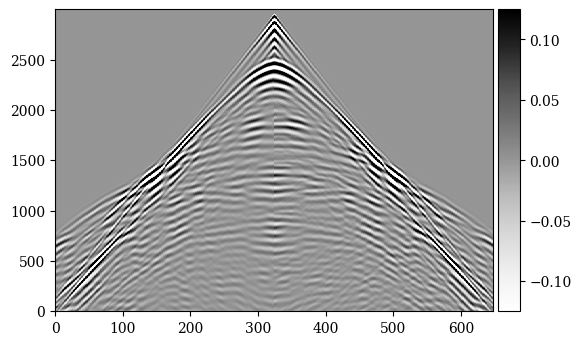

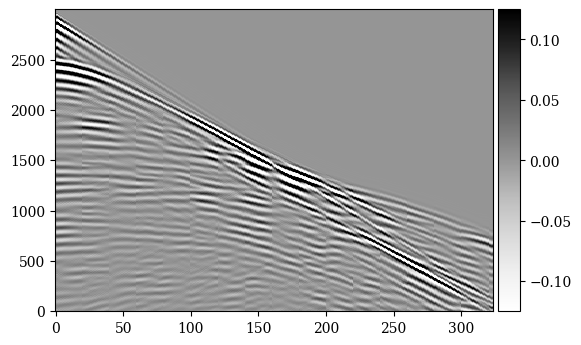

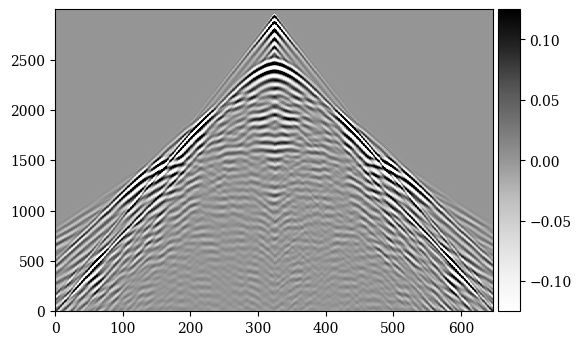

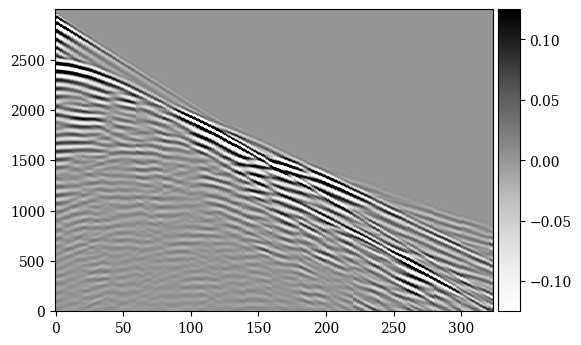

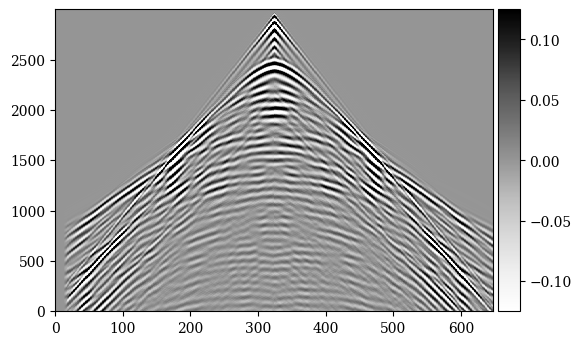

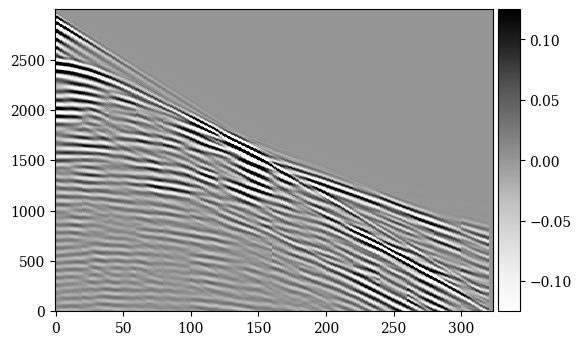

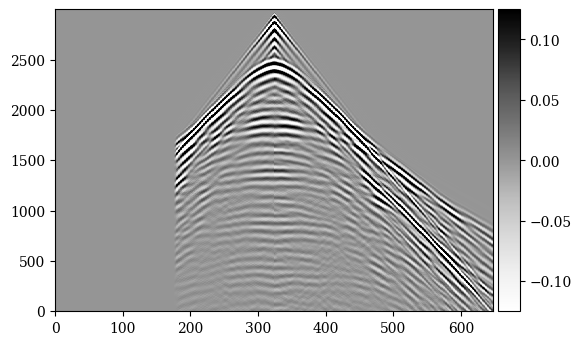

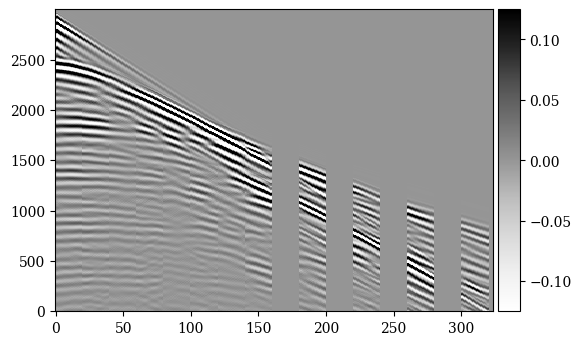

In [374]:
d.verbose = 0    # don't show redundant print outs

if d.DT is None:
    d.DT = 0.002
shots = d.get_shots(keys=['_p'])
# shots = [ld.bandpass(s, fs=1./(d.DT * d.NDT), **par_bp) for s in d.get_shots(keys=['_p'])]
print(f'Read {len(shots)} shots {shots[0].shape} into list')

for ishot in [int(np.floor(x)) for x in np.linspace(0, len(shots)-1, 4)]:
    shot_s = divmax(shots[ishot])
    shot_f = divmax(data_p[ishot, :, ::d.NDT])
    vis.plot_shot(np.concatenate([np.flip(shot_s, 0), shot_f], axis=0), pclip=0.125)
    vis.plot_compare_stripes(shot_s, shot_f, pclip=0.125)